In [1]:
import math
from dataclasses import dataclass
from functools import partial

import mlx.core as mx
import mlx.nn as nn
import mlx.core.fast as F
import tiktoken

In [2]:
# tiny shakespeare dataset
# !curl https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt -o input.txt
with open('input.txt', 'r') as f:
    text = f.read()
data = text[:1000] # first 1,000 characters
print(data[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [3]:
enc = tiktoken.get_encoding("gpt2")
tokens = enc.encode(data)
print(tokens[:24])

[5962, 22307, 25, 198, 8421, 356, 5120, 597, 2252, 11, 3285, 502, 2740, 13, 198, 198, 3237, 25, 198, 5248, 461, 11, 2740, 13]


In [15]:
buf = mx.array(tokens[:24+1])
x = buf[:-1].reshape(4, 6)
y = buf[1:].reshape(4,6)
print(x)
print(y)

array([[5962, 22307, 25, 198, 8421, 356],
       [5120, 597, 2252, 11, 3285, 502],
       [2740, 13, 198, 198, 3237, 25],
       [198, 5248, 461, 11, 2740, 13]], dtype=int32)
array([[22307, 25, 198, 8421, 356, 5120],
       [597, 2252, 11, 3285, 502, 2740],
       [13, 198, 198, 3237, 25, 198],
       [5248, 461, 11, 2740, 13, 198]], dtype=int32)


In [19]:
a = mx.array([[1,2],[3,4]])
a.shape

(2, 2)

In [47]:
from train_gpt2 import GPT, GPTConfig
from mlx.utils import tree_flatten

In [2]:
config = GPTConfig()
model = GPT(config)

In [61]:
sd = dict(tree_flatten(model))

In [2]:
from transformers import GPT2LMHeadModel

In [3]:
model_hf = GPT2LMHeadModel.from_pretrained("gpt2")
sd_hf = model_hf.state_dict()

In [4]:
print(sd_hf)

OrderedDict({'transformer.wte.weight': tensor([[-0.1101, -0.0393,  0.0331,  ..., -0.1364,  0.0151,  0.0453],
        [ 0.0403, -0.0486,  0.0462,  ...,  0.0861,  0.0025,  0.0432],
        [-0.1275,  0.0479,  0.1841,  ...,  0.0899, -0.1297, -0.0879],
        ...,
        [-0.0445, -0.0548,  0.0123,  ...,  0.1044,  0.0978, -0.0695],
        [ 0.1860,  0.0167,  0.0461,  ..., -0.0963,  0.0785, -0.0225],
        [ 0.0514, -0.0277,  0.0499,  ...,  0.0070,  0.1552,  0.1207]]), 'transformer.wpe.weight': tensor([[-1.8821e-02, -1.9742e-01,  4.0267e-03,  ..., -4.3044e-02,
          2.8267e-02,  5.4490e-02],
        [ 2.3959e-02, -5.3792e-02, -9.4879e-02,  ...,  3.4170e-02,
          1.0172e-02, -1.5573e-04],
        [ 4.2161e-03, -8.4764e-02,  5.4515e-02,  ...,  1.9745e-02,
          1.9325e-02, -2.1424e-02],
        ...,
        [-1.7987e-03,  1.6052e-03, -5.5103e-02,  ...,  1.3617e-02,
         -7.1805e-03,  3.7552e-03],
        [ 3.2105e-03,  1.5501e-03, -4.8944e-02,  ...,  2.0725e-02,
        

In [7]:
print(model_hf.state_dict().keys())

odict_keys(['transformer.wte.weight', 'transformer.wpe.weight', 'transformer.h.0.ln_1.weight', 'transformer.h.0.ln_1.bias', 'transformer.h.0.attn.c_attn.weight', 'transformer.h.0.attn.c_attn.bias', 'transformer.h.0.attn.c_proj.weight', 'transformer.h.0.attn.c_proj.bias', 'transformer.h.0.ln_2.weight', 'transformer.h.0.ln_2.bias', 'transformer.h.0.mlp.c_fc.weight', 'transformer.h.0.mlp.c_fc.bias', 'transformer.h.0.mlp.c_proj.weight', 'transformer.h.0.mlp.c_proj.bias', 'transformer.h.1.ln_1.weight', 'transformer.h.1.ln_1.bias', 'transformer.h.1.attn.c_attn.weight', 'transformer.h.1.attn.c_attn.bias', 'transformer.h.1.attn.c_proj.weight', 'transformer.h.1.attn.c_proj.bias', 'transformer.h.1.ln_2.weight', 'transformer.h.1.ln_2.bias', 'transformer.h.1.mlp.c_fc.weight', 'transformer.h.1.mlp.c_fc.bias', 'transformer.h.1.mlp.c_proj.weight', 'transformer.h.1.mlp.c_proj.bias', 'transformer.h.2.ln_1.weight', 'transformer.h.2.ln_1.bias', 'transformer.h.2.attn.c_attn.weight', 'transformer.h.2.attn.

In [8]:
len(model_hf.state_dict().keys())

149

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
from train_gpt2 import *
import mlx.optimizers as optim

In [19]:
train_loader = DataLoaderLite(B=4, T=32)
model = GPT(GPTConfig())
value_and_grad_fn = nn.value_and_grad(model, loss_fn)

num_params = sum(v.size for _, v in tree_flatten(model.trainable_parameters()))
print(f"number of parameters: {num_params}")
# for n, p in dict(tree_flatten(model.trainable_parameters())).items():
#     print(f"name: {n:<40} params: {p.size:11d}")

class MyAdamW(optim.AdamW):
    def apply_gradients(self, gradients: dict, parameters: dict):
        # this function is called for every optimizer.update()
        self.updates = []
        return super().apply_gradients(gradients, parameters)

    def apply_single(self, gradient: mx.array, parameter: mx.array, state: dict):
        # apply_single returns the parameter - update = p_updated
        # therefore, parameter - p_updated = update
        p_updated = super().apply_single(gradient, parameter, state)
        self.updates.append((p_updated, parameter - p_updated))
        return p_updated

# optimize!
x, y = train_loader.next_batch()
lr = 3e-4
optimizer = MyAdamW(learning_rate=lr)
ud = []
for i in range(100):
    # forward pass + loss + backward pass
    loss, grads = value_and_grad_fn(model, x, y)
    # optimize step
    optimizer.update(model, grads)
    mx.eval(model.state, optimizer.state)
    # DEBUG: checking parameter updates
    ud.append(
        [
            mx.log((mx.std(update) / mx.std(data))).item()
            for (data, update) in optimizer.updates
        ]
    )
    print(f"step: {i}, loss: {loss.item():.7f}")

loaded 338025 tokens
1 epoch = 2640 batches
number of parameters: 124439808
step: 0, loss: 11.1613503
step: 1, loss: 10.1794987
step: 2, loss: 12.5902071
step: 3, loss: 15.5216894
step: 4, loss: 10.7815485
step: 5, loss: 8.4398861
step: 6, loss: 9.1619663
step: 7, loss: 10.3563852
step: 8, loss: 7.7337189
step: 9, loss: 6.3794832
step: 10, loss: 5.3536177
step: 11, loss: 4.6411920
step: 12, loss: 4.4608650
step: 13, loss: 4.2709551
step: 14, loss: 4.1092033
step: 15, loss: 4.0075350
step: 16, loss: 3.9249389
step: 17, loss: 3.8912668
step: 18, loss: 3.9012809
step: 19, loss: 3.8615205
step: 20, loss: 3.7830000
step: 21, loss: 3.7274776
step: 22, loss: 3.6872230
step: 23, loss: 3.6448948
step: 24, loss: 3.6162522
step: 25, loss: 3.5984440
step: 26, loss: 3.5686383
step: 27, loss: 3.5324688
step: 28, loss: 3.4933510
step: 29, loss: 3.4610369
step: 30, loss: 3.4285874
step: 31, loss: 3.3957791
step: 32, loss: 3.3652945
step: 33, loss: 3.3403103
step: 34, loss: 3.3223631
step: 35, loss: 3.

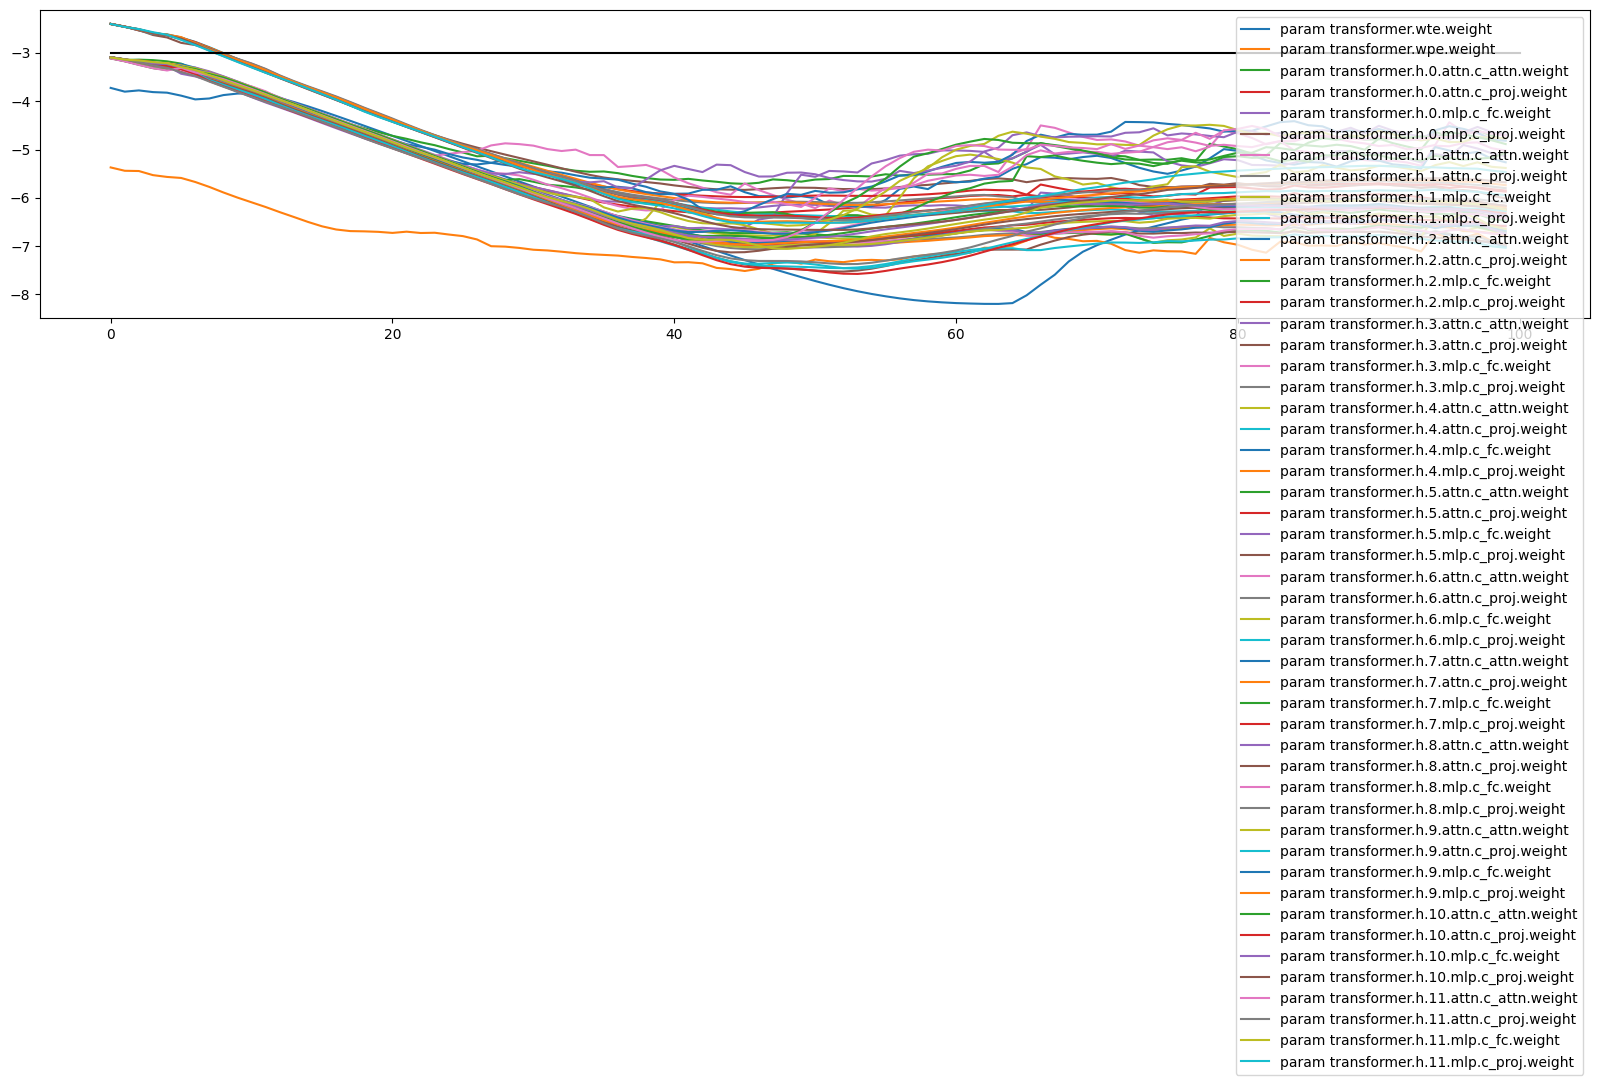

In [21]:
plt.figure(figsize=(20, 4))
legends = []
for i, (n, p) in enumerate(tree_flatten(model.trainable_parameters())):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f"param {n}")
plt.plot([0, len(ud)], [-3, -3], 'k')  # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);